In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install rdkit
!pip install biopython
!pip install posebusters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 7.5 MB/s eta 0:00:00


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1G9V_RQ3 (true pose 1): 10.100870245676854
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1G9V_RQ3 (true pose 2): 16.77145167241047
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GKC_NFH (true pose 1): 39.125710029572396
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1GKC_NFH (true pose 2): 1.5450432326990378
1GKC_NFH passes RMSD CalcRMS < 2 Å for true pose 2.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GM8_SOX (true pose 1): 3.4109325154567336
1GM8_SOX does not have any pose passing all the tests.
Number 

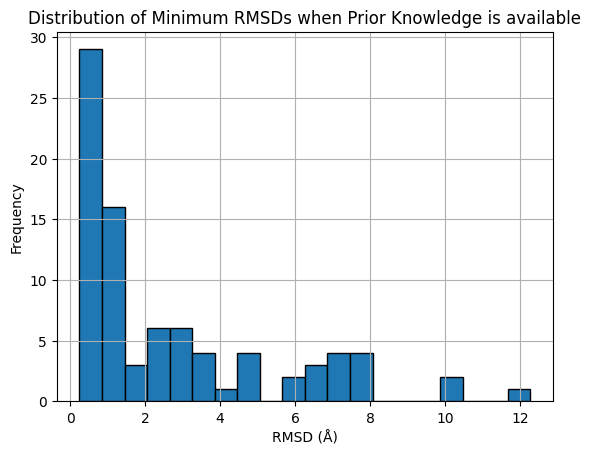

In [4]:
#@title **RMSD distribution for Astex Diverse Set when Prior Knowledge about pocket is available**

import os
import numpy as np
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Prior_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/astex_diverse_set_ids.txt'
output_file_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Prior_knowledge_Astex_output.txt'
csv_output_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Prior_knowledge_Astex_results.csv'

rmsd_prior_knowledge = []

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

with open(output_file_path, 'w') as output_file, open(csv_output_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Protein", "Min RMSD"])

    for subfolder in os.listdir(main_dir):
        if subfolder in subfolders_to_process:
            subfolder_path = os.path.join(main_dir, subfolder)
            if os.path.isdir(subfolder_path):
                predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
                true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

                if not os.path.exists(predicted_ligand_path):
                    print(f"Predicted ligand file not found for {subfolder}. Skipping...")
                    continue

                true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
                true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
                num_true_poses = len(true_ligands)
                print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

                pose_passed = False
                min_rmsd = float('inf')
                rmsd_values = []

                for i, true_ligand in enumerate(true_ligands):
                    print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                    try:
                        rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                        rmsd_values.append(rmsd_value)
                        print(f"RMSD CalcRMS for {subfolder} (true pose {i+1}): {rmsd_value}")

                        if rmsd_value < min_rmsd:
                            min_rmsd = rmsd_value

                        if is_pose_correct(rmsd_value):
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD CalcRMS < 2 Å for true pose {i+1}.")
                            break
                    except (ValueError, RuntimeError) as e:
                        print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

                rmsd_prior_knowledge.append(min_rmsd)
                output_file.write(f"{subfolder} minimum RMSD: {min_rmsd:.3f} Å\n")
                csv_writer.writerow([subfolder, min_rmsd])

                if pose_passed:
                    print(f"{subfolder} has at least one pose passing all the tests.")
                else:
                    print(f"{subfolder} does not have any pose passing all the tests.")

    print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")
    output_file.write(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}\n")
    output_file.write(f"List of minimum RMSDs: {rmsd_prior_knowledge}\n")

print(f"Output saved to {output_file_path}")

plt.hist(rmsd_prior_knowledge, bins=20, edgecolor='black')
plt.title('Distribution of Minimum RMSDs when Prior Knowledge is available')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Prior_Astex_rmsd_distribution.png')
plt.show()


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1G9V_RQ3 (true pose 1): 15.16039275480685
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1G9V_RQ3 (true pose 2): 4.8977829800839485
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GKC_NFH (true pose 1): 1.5379460180856328
1GKC_NFH passes RMSD CalcRMS < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GM8_SOX (true pose 1): 3.4411223944133886
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GPK_H

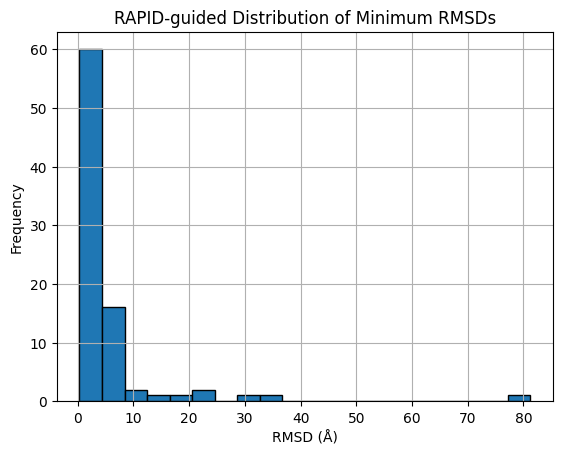

In [5]:
#@title **RMSD distribution for Astex Diverse Set when guided by ensembled RAPID-Net**

import os
import numpy as np
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Ensemble_cleaned'

subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/astex_diverse_set_ids.txt'

output_file_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/RAPID_Ensemble_Astex_output.txt'
csv_output_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/RAPID_Ensemble_Astex_rmsd_results.csv'

rmsd_RAPID = []

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

with open(output_file_path, 'w') as output_file, open(csv_output_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Protein", "Min RMSD"])

    for subfolder in os.listdir(main_dir):
        if subfolder in subfolders_to_process:
            subfolder_path = os.path.join(main_dir, subfolder)
            if os.path.isdir(subfolder_path):
                predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
                true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

                if not os.path.exists(predicted_ligand_path):
                    print(f"Predicted ligand file not found for {subfolder}. Skipping...")
                    continue

                true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
                true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
                num_true_poses = len(true_ligands)
                print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

                pose_passed = False
                min_rmsd = float('inf')
                rmsd_values = []

                for i, true_ligand in enumerate(true_ligands):
                    print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                    try:
                        rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                        rmsd_values.append(rmsd_value)
                        print(f"RMSD CalcRMS for {subfolder} (true pose {i+1}): {rmsd_value}")

                        if rmsd_value < min_rmsd:
                            min_rmsd = rmsd_value

                        if is_pose_correct(rmsd_value):
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD CalcRMS < 2 Å for true pose {i+1}.")
                            break
                    except (ValueError, RuntimeError) as e:
                        print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

                rmsd_RAPID.append(min_rmsd)
                output_file.write(f"{subfolder} minimum RMSD: {min_rmsd:.3f} Å\n")
                csv_writer.writerow([subfolder, min_rmsd])

                if pose_passed:
                    print(f"{subfolder} has at least one pose passing all the tests.")
                else:
                    print(f"{subfolder} does not have any pose passing all the tests.")

    print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")
    output_file.write(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}\n")
    output_file.write(f"List of minimum RMSDs: {rmsd_RAPID}\n")

print(f"Output saved to {output_file_path}")
print(f"CSV saved to {csv_output_path}")

plt.hist(rmsd_RAPID, bins=20, edgecolor='black')
plt.title('RAPID-guided Distribution of Minimum RMSDs')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/RAPID_Ensemble_Astex_rmsd_distribution.png')
plt.show()

In [6]:
#@title **RMSD distribution for Astex Diverse Set when guided by RAPID-Net, Run 1**

import rdkit
import os
from rdkit import Chem
from rdkit.Chem import AllChem

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_1_cleaned'
subfolders_file =  '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if is_pose_correct(rmsd_value):
                        correct_pose_count += 1
                        pose_passed = True
                        print(f"{subfolder} passes RMSD < 2 Å for true pose {i+1}.")
                        break
                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

            if pose_passed:
                print(f"{subfolder} has at least one pose passing all the tests.")
            else:
                print(f"{subfolder} does not have any pose passing all the tests.")

print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 15.104364671180315
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.876234071494108
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.509370955669341
1GKC_NFH passes RMSD < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.436892006837961
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GPK_HUP (true pose 1): 3.676065416235741
1GPK_HUP does 

In [7]:
#@title **RMSD distribution for Astex Diverse Set when guided by RAPID-Net, Run 2**

import rdkit
import os
from rdkit import Chem
from rdkit.Chem import AllChem

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_2_cleaned'
subfolders_file =  '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if is_pose_correct(rmsd_value):
                        correct_pose_count += 1
                        pose_passed = True
                        print(f"{subfolder} passes RMSD < 2 Å for true pose {i+1}.")
                        break
                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

            if pose_passed:
                print(f"{subfolder} has at least one pose passing all the tests.")
            else:
                print(f"{subfolder} does not have any pose passing all the tests.")

print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.91473290273748
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.9250616808320276
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 39.00181894476205
Checking predicted binding pose vs true binding pose number 2
RMSD for 1GKC_NFH (true pose 2): 1.4672135929280132
1GKC_NFH passes RMSD < 2 Å for true pose 2.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4504863606454093
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking pre

In [8]:
#@title **RMSD distribution for Astex Diverse Set when guided by RAPID-Net, Run 3**

import rdkit
import os
from rdkit import Chem
from rdkit.Chem import AllChem

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_3_cleaned'
subfolders_file =  '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if is_pose_correct(rmsd_value):
                        correct_pose_count += 1
                        pose_passed = True
                        print(f"{subfolder} passes RMSD < 2 Å for true pose {i+1}.")
                        break
                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

            if pose_passed:
                print(f"{subfolder} has at least one pose passing all the tests.")
            else:
                print(f"{subfolder} does not have any pose passing all the tests.")

print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.968853561979957
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.92170839851367
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.5116540609544238
1GKC_NFH passes RMSD < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4494631647547713
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GPK_HUP (true pose 1): 3.6701920627915077
1GPK_HUP doe

In [9]:
#@title **RMSD distribution for Astex Diverse Set when guided by RAPID-Net, Run 4**

import rdkit
import os
from rdkit import Chem
from rdkit.Chem import AllChem

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_4_cleaned'
subfolders_file =  '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if is_pose_correct(rmsd_value):
                        correct_pose_count += 1
                        pose_passed = True
                        print(f"{subfolder} passes RMSD < 2 Å for true pose {i+1}.")
                        break
                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

            if pose_passed:
                print(f"{subfolder} has at least one pose passing all the tests.")
            else:
                print(f"{subfolder} does not have any pose passing all the tests.")

print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.939722867576894
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.925120826944249
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.4529415304509286
1GKC_NFH passes RMSD < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4339419464613354
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GPK_HUP (true pose 1): 3.675018095193547
1GPK_HUP doe

In [10]:
#@title **RMSD distribution for Astex Diverse Set when guided by RAPID-Net, Run 5**

import rdkit
import os
from rdkit import Chem
from rdkit.Chem import AllChem

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_5_cleaned'
subfolders_file =  '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if is_pose_correct(rmsd_value):
                        correct_pose_count += 1
                        pose_passed = True
                        print(f"{subfolder} passes RMSD < 2 Å for true pose {i+1}.")
                        break
                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

            if pose_passed:
                print(f"{subfolder} has at least one pose passing all the tests.")
            else:
                print(f"{subfolder} does not have any pose passing all the tests.")

print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 15.979092861611388
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 26.711624840132806
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.4969045333013673
1GKC_NFH passes RMSD < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4457932383801935
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GPK_HUP (true pose 1): 3.667570009935431
1GPK_HUP do

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1G9V_RQ3 (true pose 1): 14.994864099417507
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1G9V_RQ3 (true pose 2): 4.890452899272213
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GKC_NFH (true pose 1): 39.10833881958261
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1GKC_NFH (true pose 2): 1.5211684055954557
1GKC_NFH passes RMSD CalcRMS < 2 Å for true pose 2.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GM8_SOX (true pose 1): 3.482897578406041
1GM8_SOX does not have any pose passing all the tests.
Number of

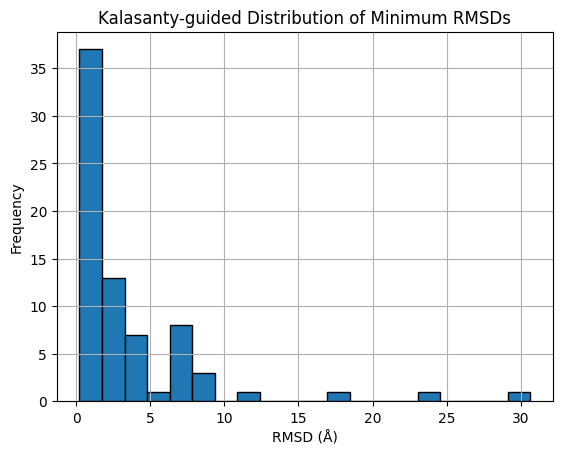

In [12]:
#@title **RMSD distribution for Astex Diverse Set when guided by Kalasanty**

import os
import numpy as np
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Kalasanty_cleaned'

subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/astex_diverse_set_ids.txt'

output_file_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_Kalasanty_output.txt'
csv_output_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_Kalasanty_rmsd_results.csv'

rmsd_Kalasanty = []

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

with open(output_file_path, 'w') as output_file, open(csv_output_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Protein", "Min RMSD"])

    for subfolder in os.listdir(main_dir):
        if subfolder in subfolders_to_process:
            subfolder_path = os.path.join(main_dir, subfolder)
            if os.path.isdir(subfolder_path):
                predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
                true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

                if not os.path.exists(predicted_ligand_path):
                    print(f"Predicted ligand file not found for {subfolder}. Skipping...")
                    continue

                true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
                true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
                num_true_poses = len(true_ligands)
                print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

                pose_passed = False
                min_rmsd = float('inf')
                rmsd_values = []

                for i, true_ligand in enumerate(true_ligands):
                    print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                    try:
                        rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                        rmsd_values.append(rmsd_value)
                        print(f"RMSD CalcRMS for {subfolder} (true pose {i+1}): {rmsd_value}")

                        if rmsd_value < min_rmsd:
                            min_rmsd = rmsd_value

                        if is_pose_correct(rmsd_value):
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD CalcRMS < 2 Å for true pose {i+1}.")
                            break
                    except (ValueError, RuntimeError) as e:
                        print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

                rmsd_Kalasanty.append(min_rmsd)
                output_file.write(f"{subfolder} minimum RMSD: {min_rmsd:.3f} Å\n")
                csv_writer.writerow([subfolder, min_rmsd])

                if pose_passed:
                    print(f"{subfolder} has at least one pose passing all the tests.")
                else:
                    print(f"{subfolder} does not have any pose passing all the tests.")

    print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")
    output_file.write(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}\n")
    output_file.write(f"List of minimum RMSDs: {rmsd_Kalasanty}\n")

print(f"Output saved to {output_file_path}")
print(f"CSV saved to {csv_output_path}")

plt.hist(rmsd_Kalasanty, bins=20, edgecolor='black')
plt.title('Kalasanty-guided Distribution of Minimum RMSDs')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_Kalasanty_rmsd_distribution.png')
plt.show()


Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1G9V_RQ3 (true pose 1): 14.952822758262066
Checking predicted binding pose vs true binding pose number 2
RMSD CalcRMS for 1G9V_RQ3 (true pose 2): 4.8874223799463055
1G9V_RQ3 does not have any pose passing all the tests.
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GKC_NFH (true pose 1): 1.4801455702365582
1GKC_NFH passes RMSD CalcRMS < 2 Å for true pose 1.
1GKC_NFH has at least one pose passing all the tests.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GM8_SOX (true pose 1): 3.459957447956068
1GM8_SOX does not have any pose passing all the tests.
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs true binding pose number 1
RMSD CalcRMS for 1GPK_H

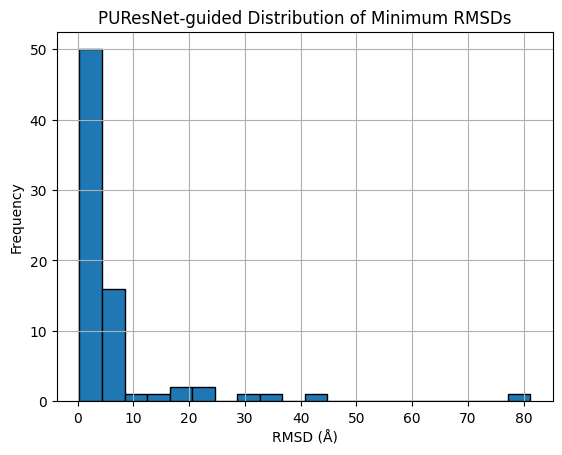

In [13]:
#@title **RMSD distribution for Astex Diverse Set when guided by PUResNet V1**

import os
import numpy as np
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError as e:
        raise RuntimeError(f"No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_PUResNet_cleaned'

subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/astex_diverse_set_ids.txt'

output_file_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Kalasanty_Astex_output.txt'
csv_output_path = '/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_PUResNet_rmsd_results.csv'

rmsd_PUResNet = []

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

with open(output_file_path, 'w') as output_file, open(csv_output_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Protein", "Min RMSD"])

    for subfolder in os.listdir(main_dir):
        if subfolder in subfolders_to_process:
            subfolder_path = os.path.join(main_dir, subfolder)
            if os.path.isdir(subfolder_path):
                predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
                true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

                if not os.path.exists(predicted_ligand_path):
                    print(f"Predicted ligand file not found for {subfolder}. Skipping...")
                    continue

                true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
                true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
                num_true_poses = len(true_ligands)
                print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

                pose_passed = False
                min_rmsd = float('inf')
                rmsd_values = []

                for i, true_ligand in enumerate(true_ligands):
                    print(f"Checking predicted binding pose vs true binding pose number {i+1}")

                    try:
                        rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                        rmsd_values.append(rmsd_value)
                        print(f"RMSD CalcRMS for {subfolder} (true pose {i+1}): {rmsd_value}")

                        if rmsd_value < min_rmsd:
                            min_rmsd = rmsd_value

                        if is_pose_correct(rmsd_value):
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD CalcRMS < 2 Å for true pose {i+1}.")
                            break
                    except (ValueError, RuntimeError) as e:
                        print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")

                rmsd_PUResNet.append(min_rmsd)
                output_file.write(f"{subfolder} minimum RMSD: {min_rmsd:.3f} Å\n")
                csv_writer.writerow([subfolder, min_rmsd])

                if pose_passed:
                    print(f"{subfolder} has at least one pose passing all the tests.")
                else:
                    print(f"{subfolder} does not have any pose passing all the tests.")

    print(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}")
    output_file.write(f"Number of subfolders where poses have RMSD < 2 Å: {correct_pose_count}\n")
    output_file.write(f"List of minimum RMSDs: {rmsd_PUResNet}\n")

print(f"Output saved to {output_file_path}")
print(f"CSV saved to {csv_output_path}")

plt.hist(rmsd_PUResNet, bins=20, edgecolor='black')
plt.title('PUResNet-guided Distribution of Minimum RMSDs')
plt.xlabel('RMSD (Å)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_PUResNet_rmsd_distribution.png')
plt.show()


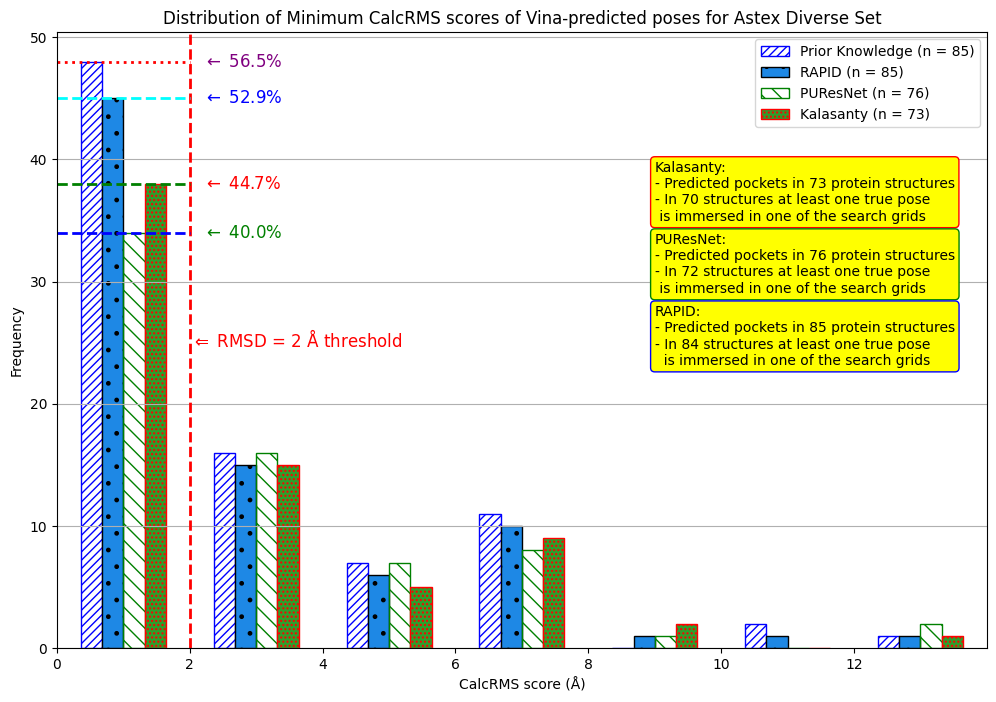

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n_prior_knowledge = 85
n_Kalasanty = 73
n_PUResNet = 76
n_RAPID = 85

bins = 20
hist_prior_knowledge, bin_edges = np.histogram(rmsd_prior_knowledge, bins=bins, range=(0, 40))
hist_Kalasanty, _ = np.histogram(rmsd_Kalasanty, bins=bins, range=(0, 40))
hist_PUResNet, _ = np.histogram(rmsd_PUResNet, bins=bins, range=(0, 40))
hist_RAPID, _ = np.histogram(rmsd_RAPID, bins=bins, range=(0, 40))

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 0.32

plt.figure(figsize=(12, 8))

plt.bar(bin_centers - 1.5 * width, hist_prior_knowledge, width=width, edgecolor='blue', fill=False, hatch='////', label=f'Prior Knowledge (n = 85)')
plt.bar(bin_centers - 0.5 * width, hist_RAPID, width=width, color='#1E88E5', hatch='.', edgecolor='black', label=f'RAPID (n = 85)')
plt.bar(bin_centers + 0.5 * width, hist_PUResNet, width=width, edgecolor='green', fill=False, hatch='\\\\', label=f'PUResNet (n = 76)')
plt.bar(bin_centers + 1.5 * width, hist_Kalasanty, width=width, edgecolor='red', hatch='....', label=f'Kalasanty (n = 73)')

plt.axvline(x=2, color='red', linestyle='--', linewidth=2)
plt.text(1.95, plt.ylim()[1]*0.5, ' $\Leftarrow$ RMSD = 2 Å threshold', color='red', verticalalignment='center', fontsize=12)

plt.plot([0, 2], [48, 48], color='red', linestyle='dotted', linewidth=2)

plt.plot([0, 2], [38, 38], color='green', linestyle='--', linewidth=2)

plt.plot([0, 2], [34, 34], color='blue', linestyle='--', linewidth=2)

plt.plot([0, 2], [45, 45], color='cyan', linestyle='--', linewidth=2)

plt.text(2.2, 48, '$\leftarrow$ 56.5%', color='purple', verticalalignment='center', fontsize=12)

plt.text(2.2, 38, '$\leftarrow$ 44.7%', color='red', verticalalignment='center', fontsize=12)

plt.text(2.2, 34, '$\leftarrow$ 40.0%', color='green', verticalalignment='center', fontsize=12)

plt.text(2.2, 45, '$\leftarrow$ 52.9%', color='blue', verticalalignment='center', fontsize=12)

plt.text(9, 35, 'Kalasanty:\n- Predicted pockets in 73 protein structures\n- In 70 structures at least one true pose \n is immersed in one of the search grids',
         fontsize=10, bbox=dict(boxstyle="round", facecolor='yellow', edgecolor='red'))

plt.text(9, 30 - 0.9, 'PUResNet:\n- Predicted pockets in 76 protein structures\n- In 72 structures at least one true pose \n is immersed in one of the search grids',
         fontsize=10, bbox=dict(boxstyle="round", facecolor='yellow', edgecolor='green'))

plt.text(9, 25 - 1.8, 'RAPID:\n- Predicted pockets in 85 protein structures\n- In 84 structures at least one true pose \n  is immersed in one of the search grids',
         fontsize=10, bbox=dict(boxstyle="round", facecolor='yellow', edgecolor='blue'))

plt.title('Distribution of Minimum CalcRMS scores of Vina-predicted poses for Astex Diverse Set')
plt.xlabel('CalcRMS score (Å)')
plt.ylabel('Frequency')
plt.xlim(0, 14)
plt.xticks(ticks=np.arange(0, 14, 2))
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.savefig('/content/gdrive/MyDrive/Docking_benchmarks/posebusters_benchmark_set/Astex_rmsd_distribution_side_by_side_histogram_styled.png')
plt.show()

In [15]:
#@title **Chemical validity tests, Astex when prior knowledge is available**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Prior_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 10.100870245676854
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 16.77145167241047
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 39.125710029572396
Checking predicted binding pose vs true binding pose number 2
RMSD for 1GKC_NFH (true pose 2): 1.5450432326990378
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Prior_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 2): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 2.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX

In [19]:
#@title **Chemical validity tests, Astex when guided by ensembled RAPID-Net**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Ensemble_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 15.16039275480685
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.8977829800839485
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.5379460180856328
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Ensemble_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 1): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 1.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4411223944133886
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose 

In [20]:
#@title **Chemical validity tests, Astex when guided by RAPID-Net, Run 1**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_1_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 15.104364671180315
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.876234071494108
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.509370955669341
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_1_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 1): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 1.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.436892006837961
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs 

In [21]:
#@title **Chemical validity tests, Astex when guided by RAPID-Net, Run 2**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_2_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.91473290273748
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.9250616808320276
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 39.00181894476205
Checking predicted binding pose vs true binding pose number 2
RMSD for 1GKC_NFH (true pose 2): 1.4672135929280132
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_2_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 2): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 2.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SO

In [22]:
#@title **Chemical validity tests, Astex when guided by RAPID-Net, Run 3**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_3_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.968853561979957
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.92170839851367
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.5116540609544238
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_3_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 1): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 1.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4494631647547713
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose vs

In [23]:
#@title **Chemical validity tests, Astex when guided by RAPID-Net, Run 4**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_4_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 14.939722867576894
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 4.925120826944249
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.4529415304509286
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_4_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 1): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 1.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4339419464613354
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose v

In [24]:
#@title **Chemical validity tests, Astex when guided by RAPID-Net, Run 5**

import os
from rdkit import Chem
from rdkit.Chem import AllChem
import subprocess
import re

def calculate_rmsd(true_ligand, predicted_ligand_path):
    predicted_ligand = Chem.MolFromMolFile(predicted_ligand_path)
    if predicted_ligand is None:
        raise ValueError(f"Could not load predicted ligand from {predicted_ligand_path}")

    try:
        rmsd_value = AllChem.CalcRMS(true_ligand, predicted_ligand)
    except RuntimeError:
        raise RuntimeError("No sub-structure match found between the reference and probe mol")

    return rmsd_value

def is_pose_correct(rmsd_value, threshold=2.0):
    return rmsd_value <= threshold

main_dir = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_5_cleaned'
subfolders_file = '/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_ids.txt'

with open(subfolders_file, 'r') as f:
    subfolders_to_process = {line.strip() for line in f}

print(f"Number of subfolders to process: {len(subfolders_to_process)}")

correct_pose_count = 0

for subfolder in os.listdir(main_dir):
    if subfolder in subfolders_to_process:
        subfolder_path = os.path.join(main_dir, subfolder)
        if os.path.isdir(subfolder_path):
            predicted_ligand_path = os.path.join(subfolder_path, f"{subfolder}_predicted_pose.sdf")
            protein_path = os.path.join(subfolder_path, f"{subfolder}_protein_reduce_rm_bad.pdb")
            true_ligands_path = os.path.join(subfolder_path, f"{subfolder}_ligands.sdf")

            if not os.path.isfile(predicted_ligand_path):
                print(f"Predicted pose file not found for {subfolder}, skipping.")
                continue

            if not os.path.isfile(true_ligands_path):
                print(f"True ligands file not found for {subfolder}, skipping.")
                continue

            true_ligands_supplier = Chem.SDMolSupplier(true_ligands_path)
            true_ligands = [ligand for ligand in true_ligands_supplier if ligand is not None]
            num_true_poses = len(true_ligands)
            print(f"Number of true binding poses in {subfolder}: {num_true_poses}")

            if num_true_poses == 0:
                print(f"No valid true ligands found for {subfolder}, skipping.")
                continue

            pose_passed = False

            for i, true_ligand in enumerate(true_ligands):
                print(f"Checking predicted binding pose vs true binding pose number {i+1}")
                try:
                    rmsd_value = calculate_rmsd(true_ligand, predicted_ligand_path)
                    print(f"RMSD for {subfolder} (true pose {i+1}): {rmsd_value}")

                    if not is_pose_correct(rmsd_value):
                        continue

                    if not os.path.isfile(protein_path):
                        print(f"Protein file not found for {subfolder}, skipping PoseBusters test.")
                        continue

                    command = [
                        'bust',
                        predicted_ligand_path,
                        '-l', true_ligands_path,
                        '-p', protein_path
                    ]

                    result = subprocess.run(command, capture_output=True, text=True)
                    if result.returncode != 0:
                        print(f"PoseBusters command failed for {subfolder} (true pose {i+1}). Error:\n{result.stderr}")
                        continue

                    output = result.stdout
                    print(output)

                    match = re.search(r'passes \((\d+) / (\d+)\)', output)
                    if match:
                        passed_tests = int(match.group(1))
                        total_tests = int(match.group(2))

                        print(f"PoseBusters test result for {subfolder} (true pose {i+1}): {passed_tests} / {total_tests}")

                        if passed_tests == total_tests:
                            correct_pose_count += 1
                            pose_passed = True
                            print(f"{subfolder} passes RMSD < 2 Å and all PoseBusters tests for true pose {i+1}.")
                            break
                    else:
                        print(f"PoseBusters test did not pass for {subfolder} (true pose {i+1}).")

                except (ValueError, RuntimeError) as e:
                    print(f"Error occurred for {subfolder} (true pose {i+1}): {e}")
                except FileNotFoundError as e:
                    print(f"File not found error for {subfolder}: {e}")
                except Exception as e:
                    print(f"Unexpected error for {subfolder} (true pose {i+1}): {e}")

print(f"Number of subfolders where poses have RMSD < 2 Å and pass the PB test: {correct_pose_count}")

Number of subfolders to process: 85
Number of true binding poses in 1G9V_RQ3: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1G9V_RQ3 (true pose 1): 15.979092861611388
Checking predicted binding pose vs true binding pose number 2
RMSD for 1G9V_RQ3 (true pose 2): 26.711624840132806
Number of true binding poses in 1GKC_NFH: 2
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GKC_NFH (true pose 1): 1.4969045333013673
/content/gdrive/MyDrive/Docking_benchmarks/Interesting_Cases/Astex/astex_diverse_set_Model_5_cleaned/1GKC_NFH/1GKC_NFH_predicted_pose.sdf mol_at_pos_0  passes (26 / 26)

PoseBusters test result for 1GKC_NFH (true pose 1): 26 / 26
1GKC_NFH passes RMSD < 2 Å and all PoseBusters tests for true pose 1.
Number of true binding poses in 1GM8_SOX: 1
Checking predicted binding pose vs true binding pose number 1
RMSD for 1GM8_SOX (true pose 1): 3.4457932383801935
Number of true binding poses in 1GPK_HUP: 1
Checking predicted binding pose 

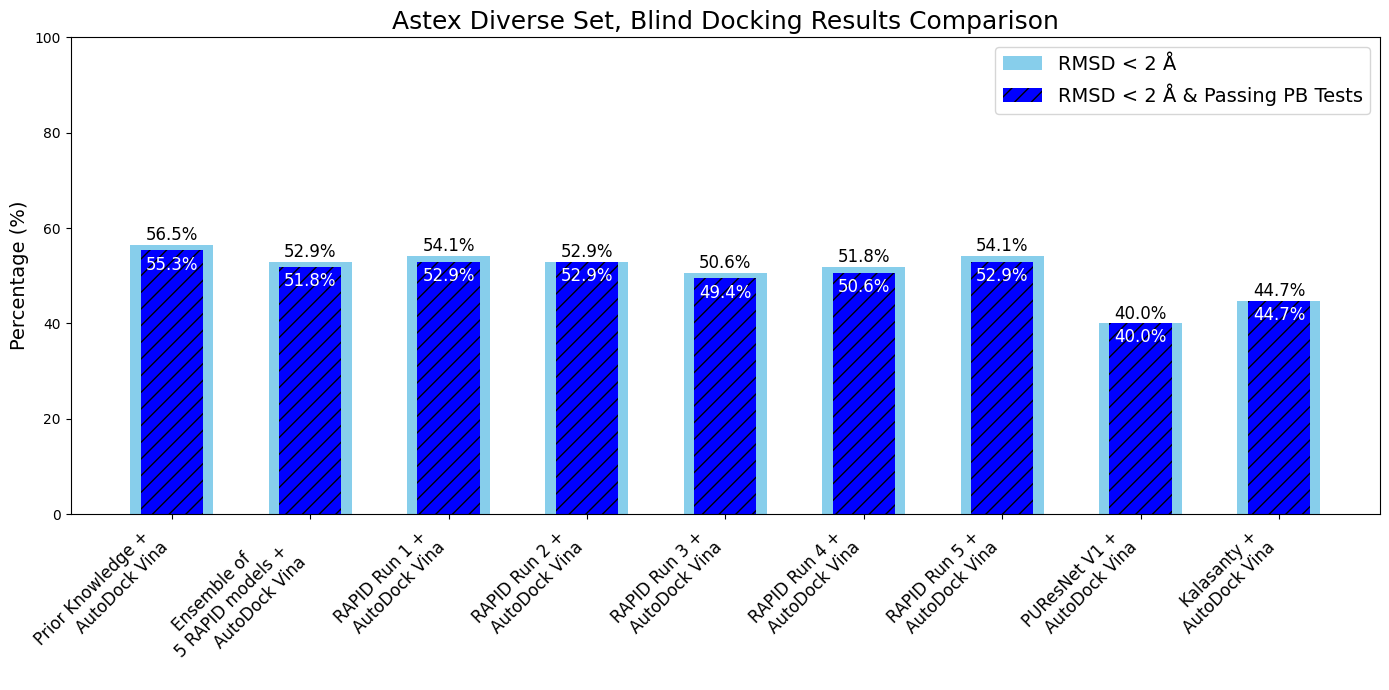

In [26]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "Prior Knowledge + \n AutoDock Vina",
    "Ensemble of       \n 5 RAPID models + \n AutoDock Vina",
    "RAPID Run 1 + \n AutoDock Vina",
    "RAPID Run 2 + \n AutoDock Vina",
    "RAPID Run 3 + \n AutoDock Vina",
    "RAPID Run 4 + \n AutoDock Vina",
    "RAPID Run 5 + \n AutoDock Vina",
    "PUResNet V1 + \n AutoDock Vina",
    "Kalasanty + \n AutoDock Vina"]


rmsd_less_than_2 = [48, 45, 46, 45, 43, 44, 46, 34, 38]  # Counts for RMSD < 2 Å
passing_pb_tests = [47, 44, 45, 45, 42, 43, 45, 34, 38]   # Counts for RMSD < 2 Å and passing PB tests

total = 85
rmsd_less_than_2_percent = [count / total * 100 for count in rmsd_less_than_2]
passing_pb_tests_percent = [count / total * 100 for count in passing_pb_tests]

x = np.arange(len(models))
bar_width = 0.6
bar_gap = 0.15

plt.figure(figsize=(14, 7))

bars1 = plt.bar(x, rmsd_less_than_2_percent, width=bar_width, label='RMSD < 2 Å', color='skyblue')

bars2 = plt.bar(x, passing_pb_tests_percent, width=bar_width - bar_gap, label='RMSD < 2 Å & Passing PB Tests',
                color='blue', hatch='//')

for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{rmsd_less_than_2_percent[i]:.1f}%', ha='center', fontsize=12, color='black')

for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 4,
             f'{passing_pb_tests_percent[i]:.1f}%', ha='center', fontsize=12, color='white')

plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Astex Diverse Set, Blind Docking Results Comparison', fontsize=18)
plt.xticks(x, models, rotation=45, ha='right', fontsize=12)
plt.ylim(0, 100)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

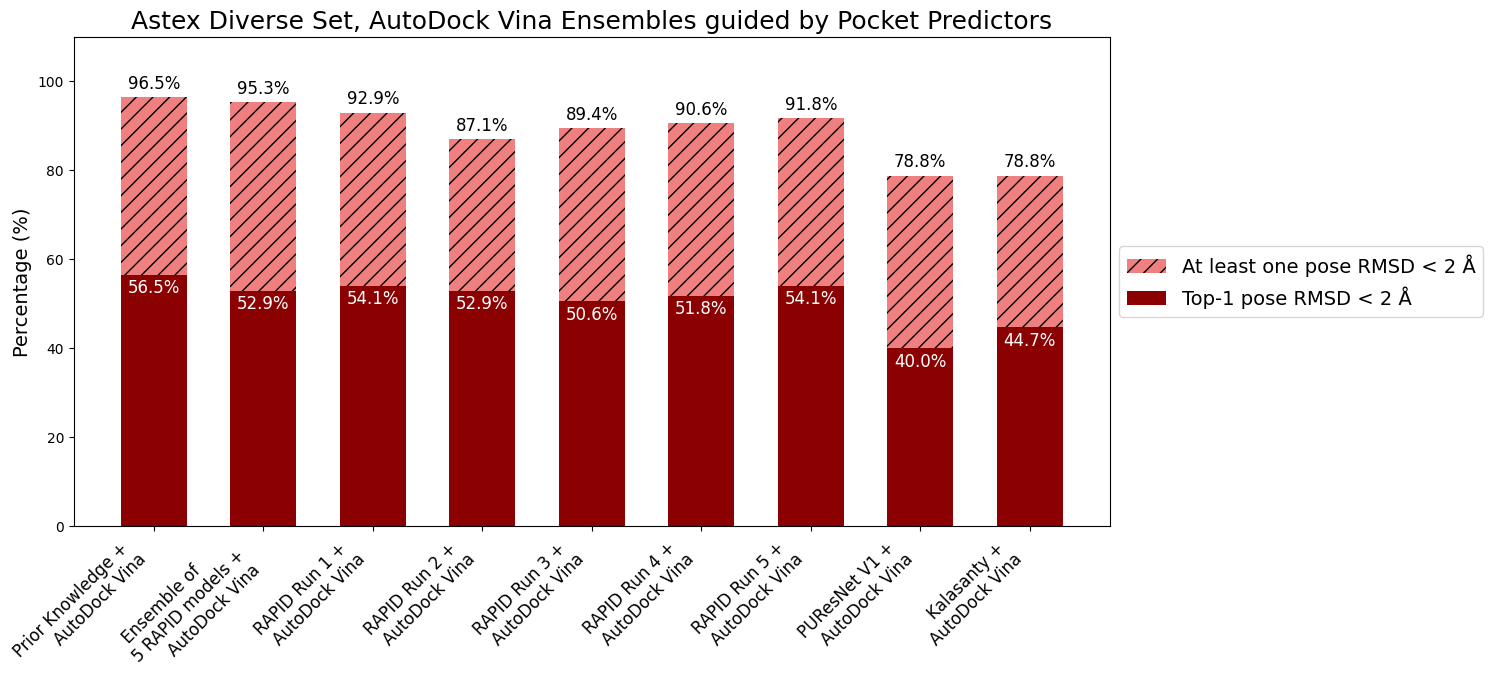

In [27]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    "Prior Knowledge +  \n AutoDock Vina ",
    " Ensemble of        \n5 RAPID models +\n AutoDock Vina",
    "RAPID Run 1 +  \n AutoDock Vina ",
    "RAPID Run 2 +  \n AutoDock Vina ",
    "RAPID Run 3 +  \n AutoDock Vina ",
    "RAPID Run 4 +  \n AutoDock Vina ",
    "RAPID Run 5 +  \n AutoDock Vina ",
    "PUResNet V1 +  \n AutoDock Vina ",
    "Kalasanty +  \n AutoDock Vina "
]

rmsd_less_than_2_at_least_one = [82, 81, 79, 74, 76, 77, 78, 67, 67]
rmsd_less_than_2_top1 = [48, 45, 46, 45, 43, 44, 46, 34, 38]

total = 85

percentages_at_least_one = [count / total * 100 if count is not None else None for count in rmsd_less_than_2_at_least_one]
percentages_top1 = [count / total * 100 if count is not None else None for count in rmsd_less_than_2_top1]


spacing_factor = 2

x = np.arange(len(models))
bar_width = 0.6

plt.figure(figsize=(15, 7))

bars1 = plt.bar(x, percentages_at_least_one, width=bar_width, label='At least one pose RMSD < 2 Å',
                color='lightcoral', hatch='//')

bars2 = plt.bar(x, percentages_top1, width=bar_width, label='Top-1 pose RMSD < 2 Å',
                color='darkred')

for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, min(bar.get_height() + 2, 100),
             f'{percentages_at_least_one[i]:.1f}%', ha='center', fontsize=12, color='black')

for i, bar in enumerate(bars2):
    if percentages_top1[i] is not None:
        plt.text(bar.get_x() + bar.get_width() / 2, min(percentages_top1[i] - 4, 100),
                 f'{percentages_top1[i]:.1f}%', ha='center', fontsize=12, color='white')


plt.ylim(0, 110)

plt.xticks(x, models, rotation=45, ha='right', fontsize=12, y=0.01)

plt.ylabel('Percentage (%)', fontsize=14)
plt.title('Astex Diverse Set, AutoDock Vina Ensembles guided by Pocket Predictors', fontsize=18)

plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
